# Azure Automated ML

In [2]:
import azureml.core
import pandas as pd
from azureml.core.workspace import Workspace
from azureml.train.automl.run import AutoMLRun
import time
import logging
from sklearn import datasets
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import random
import numpy as np

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Workspace 구성
- project 폴더 경로 생성 및 config.json파일이 있어야 함
- 구독 ID, 리소스그룹, Workspace 이름 필요 (생성도 Jupyter 내에서 할 수 있음)

In [22]:
#ws = Workspace.from_config()
# project folder to save your local files
#project_folder = './sample_projects/automl-local-classification'
# choose a name for the run history container in the workspace
#experiment_name = 'automl-classifier'

In [25]:
#!cat config.json

## Workspace 정보 출력
- azureml SDK Version은 0.1.65

In [23]:
import os

# output = {}
# output['SDK version'] = azureml.core.VERSION
# output['Subscription ID'] = ws.subscription_id
# output['Workspace'] = ws.name
# output['Resource Group'] = ws.resource_group
# output['Location'] = ws.location
# output['Project Directory'] = project_folder
# pd.set_option('display.max_colwidth', -1)
# pd.DataFrame(data=output, index=['']).T

## 데이터 로드 - MNIST 손글씨 예제

In [14]:
from sklearn import datasets

digits = datasets.load_digits()

# Exclude the first 100 rows from training so that they can be used for test.
X_train = digits.data[100:,:]
y_train = digits.target[100:]

## Automated ML 모델 학습
> 자동화 기계 학습에서 사용할 수 있는 구성 옵션
- 실험 유형 선택 (회귀와 분류)
- 회귀 : linear_model, GradientBoostingRegressor, Decision Tree 등 ...
- 분류 : Logist Rergression, SVC, RandomForestClassifier 등 ...
- 데이터 원본, 형식 및 데이터 가져오기 : Azure Blob Storage 지원 (배열 또는 데이터프레임)
- 계산 대상 선택(로컬 또는 원격) 
- 원격으로 할 경우 data_script 매개변수를 지정하고 get_data 파일 경로를 제공해야 함.
- 자동화된 ML 실험 설정
- 자동화된 ML 실험 실행
- 모델 메트릭 탐색
- 모델 등록 및 배포

https://docs.microsoft.com/ko-kr/azure/machine-learning/service/how-to-configure-auto-train#select-your-experiment-type


## 1. 실험 설정 구성
- 12,000초 동안 AUC를 사용하여 '분류'하는 실험입니다.
- primary_metric은 모델 작성시 최적화하려는 메트릭. AUC이기 때문에 Auto ML에서는 최대의 AUC를 가진 모델을 찾는다.
- exit_score = 최소 얼만큼의 primary_metric에 충족하는 모델을 찾아달라.
- interations = 최대 파이프라인에서 발생하는 학습 수. 고품질 모델까지 얻으려면 250개 이상 사용해야 함.
- n_cross_validations = 교차 유효성 검사 분할의 수
- preprocess = 실험에 입력에 대한 전처리를 수행 (누락된 데이터를 평균 값으로 넣거나 핫 인코딩으로 변환)
- balacklist_algos = 사용하지 않을 알고리즘을 넣어 시간 절약 가능
- verbosity = 원하는 정보 출력 

https://aka.ms/aml-notebooks

In [16]:
from azureml.train.automl import AutoMLConfig

##Local compute 
Automl_config = AutoMLConfig(task = 'classification',
                             primary_metric = 'AUC_weighted',
                             max_time_sec = 12000,
                             iterations = 20,
                             n_cross_validations = 3,
                             preprocess = False,
                             exit_score = 0.9985,
                             blacklist_algos = ['kNN','LinearSVM'],
                             X = X_train,
                             y = y_train,
                             path=project_folder)

## 2. 실험 실행 - local에서 실행

In [17]:
from azureml.core.experiment import Experiment
experiment=Experiment(ws, experiment_name)
local_run = experiment.submit(Automl_config, show_output=True)

Parent Run ID: AutoML_c55c4759-bf3e-44fd-b3e2-cdea9a43a75c
***********************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
***********************************************************************************************

 ITERATION     PIPELINE                               DURATION                METRIC      BEST
         0      MaxAbsScaler SGDClassifierWrapper     0:00:53.482223           0.994     0.994
         1      RobustScaler NBWrapper                0:00:48.743204           0.992     0.994
         2      RobustScaler KNeighborsClassifier     0:00:51.294847           0.999     0.999
Stopping criteria reached at iteration {0}. Ending experiment.

## 3. 결과 탐색

In [18]:
from azureml.train.widgets import RunDetails
RunDetails(local_run).show()

_AutoML(widget_settings={'childWidgetDisplay': 'popup'})

## 4. 모든 반복 검색

In [19]:
children = list(local_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

import pandas as pd
rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2
AUC_macro,0.993649,0.991635,0.999369
AUC_micro,0.974963,0.992614,0.999472
AUC_weighted,0.993672,0.991555,0.999378
AUC_weighted_max,0.993672,0.993672,0.999378
accuracy,0.793793,0.900423,0.979377
average_precision_score_macro,0.956203,0.944573,0.996192
average_precision_score_micro,0.844175,0.947317,0.996926
average_precision_score_weighted,0.956788,0.944635,0.996167
balanced_accuracy,0.881860,0.944746,0.988598
f1_score_macro,0.790292,0.901021,0.979316


## 5. 최적 모델 등록 - local_run 개체 사용.

In [20]:
# find the run with the highest accuracy value.
best_run, fitted_model = local_run.get_output()

# register model in workspace
description = 'Automated Machine Learning Model'
tags = None
local_run.register_model(description=description, tags=tags)
local_run.model_id # Use this id to deploy the model as a web service in Azure

Registering model AutoMLc55c4759bbest


'AutoMLc55c4759bbest'

## 최적 모델 테스트

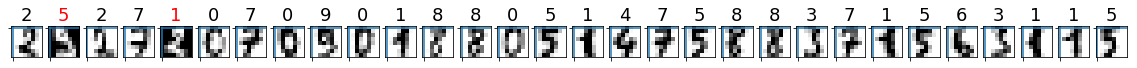

In [13]:
# find 30 random samples from test set
n = 30
X_test = digits.data[:100, :]
y_test = digits.target[:100]
sample_indices = np.random.permutation(X_test.shape[0])[0:n]
test_samples = X_test[sample_indices]


# predict using the  model
result = fitted_model.predict(test_samples)

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize = (20, 1))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')

    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys

    plt.text(x = 2, y = -2, s = result[i], fontsize = 18, color = font_color)
    plt.imshow(X_test[s].reshape(8, 8), cmap = clr_map)

    i = i + 1
plt.show()